# Import Libraries

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

# Import and Preprocess Data

In [25]:
eth_raw_data = pd.read_csv('Crypto_Data/gemini_ETHUSD_1min.csv')
ltc_raw_data = pd.read_csv('Crypto_Data/gemini_LTCUSD_1min.csv')

In [26]:
eth_raw_data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1577836800000,1/1/20 0:00,ETHUSD,128.84,128.84,128.74,128.74,0.010000
1,1577836860000,1/1/20 0:01,ETHUSD,128.74,128.74,128.74,128.74,0.000000
2,1577836920000,1/1/20 0:02,ETHUSD,128.74,128.74,128.74,128.74,0.000000
3,1577836980000,1/1/20 0:03,ETHUSD,128.74,128.74,128.74,128.74,0.000000
4,1577837040000,1/1/20 0:04,ETHUSD,128.74,128.74,128.49,128.50,4.039458


In [27]:
ltc_raw_data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1577836800000,1/1/20 0:00,LTCUSD,41.26,41.26,41.26,41.26,0.0
1,1577836860000,1/1/20 0:01,LTCUSD,41.26,41.26,41.26,41.26,0.0
2,1577836920000,1/1/20 0:02,LTCUSD,41.26,41.26,41.26,41.26,0.0
3,1577836980000,1/1/20 0:03,LTCUSD,41.26,41.26,41.26,41.26,0.0
4,1577837040000,1/1/20 0:04,LTCUSD,41.26,41.26,41.26,41.26,0.0


In [28]:
eth_raw_data['Date'] = pd.to_datetime(eth_raw_data['Date'])
eth_raw_data.set_index('Date', inplace=True)

ltc_raw_data['Date'] = pd.to_datetime(ltc_raw_data['Date'])
ltc_raw_data.set_index('Date', inplace=True)

In [37]:
eth_data = eth_raw_data[['Open']]
ltc_data = ltc_raw_data[['Open']]

# Functions

In [38]:
def simple_moving_averages(data, smaller_window, larger_window):
    new_df = pd.DataFrame()
    new_df['Open'] = data['Open']
    new_df['smaller'] = data.Open.rolling(smaller_window, min_periods=smaller_window).mean()
    new_df['larger'] = data.Open.rolling(larger_window, min_periods=larger_window).mean()
    return new_df

def exponential_moving_averages(data, smaller_window, larger_window):
    new_df = pd.DataFrame()
    new_df['Open'] = data['Open']
    new_df['smaller'] = data.Open.ewm(smaller_window, min_periods=smaller_window).mean()
    new_df['larger'] = data.Open.ewm(larger_window, min_periods=larger_window).mean()
    return new_df

def plot_data(data):
    colors = ['black', 'green', 'red']
    data[['Open', 'smaller', 'larger']].plot(color=colors, linewidth=1, figsize=(15,8))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(labels =['ETHUSD', 'SMA_smaller', 'SMA_larger'], fontsize=14)
    plt.xlabel('Datetime (per min)', fontsize=16)
    plt.ylabel('USD', fontsize=16)
    plt.show()

# Create Plots

In [39]:
eth_sma_plot_data = simple_moving_averages(eth_data, 30, 180)
eth_ema_plot_data = exponential_moving_averages(eth_data, 30, 180)

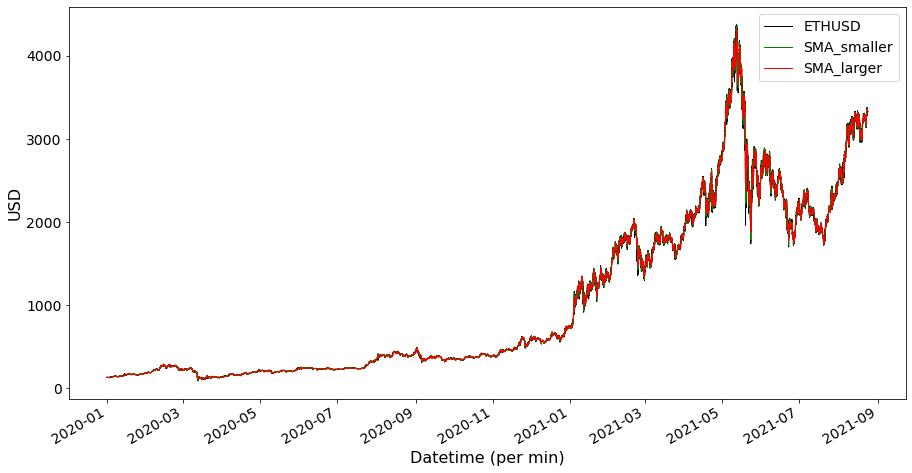

In [42]:
plot_data(eth_sma_plot_data)

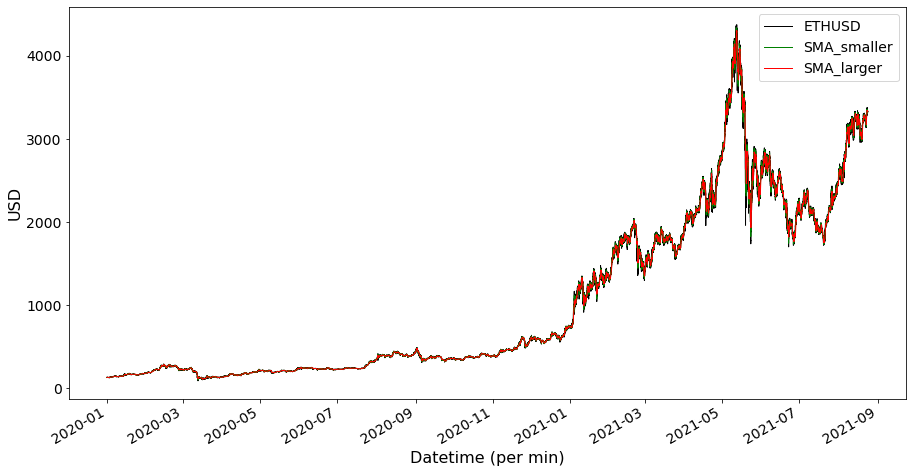

In [43]:
plot_data(eth_ema_plot_data)

## Comparing Upward and Downward Trends

In [59]:
upward_eth_sma_plot_data = eth_sma_plot_data[((eth_sma_plot_data.index >= '2021-05-01')&(eth_sma_plot_data.index <= '2021-05-02'))]
upward_eth_ema_plot_data = eth_ema_plot_data[((eth_ema_plot_data.index >= '2021-05-01')&(eth_ema_plot_data.index <= '2021-05-02'))]

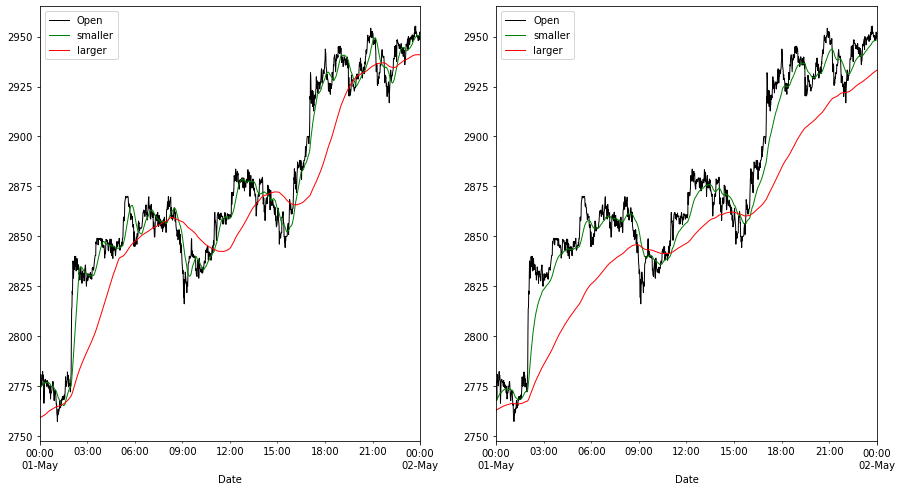

In [60]:
fig, axes = plt.subplots(nrows=1, ncols=2)

colors = ['black', 'green', 'red']
upward_eth_sma_plot_data[['Open', 'smaller', 'larger']].plot(color=colors, linewidth=1, figsize=(15,8), ax=axes[0])
upward_eth_ema_plot_data[['Open', 'smaller', 'larger']].plot(color=colors, linewidth=1, figsize=(15,8), ax=axes[1])

plt.show()

In [61]:
downward_eth_sma_plot_data = eth_sma_plot_data[((eth_sma_plot_data.index >= '2021-05-18')&(eth_sma_plot_data.index <= '2021-05-20'))]
downward_eth_ema_plot_data = eth_ema_plot_data[((eth_ema_plot_data.index >= '2021-05-18')&(eth_ema_plot_data.index <= '2021-05-20'))]

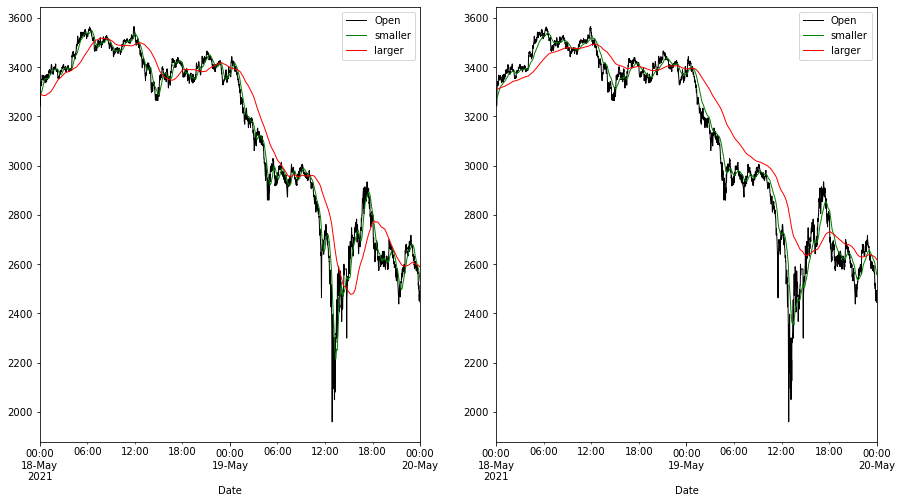

In [62]:
fig, axes = plt.subplots(nrows=1, ncols=2)

colors = ['black', 'green', 'red']
downward_eth_sma_plot_data[['Open', 'smaller', 'larger']].plot(color=colors, linewidth=1, figsize=(15,8), ax=axes[0])
downward_eth_ema_plot_data[['Open', 'smaller', 'larger']].plot(color=colors, linewidth=1, figsize=(15,8), ax=axes[1])

plt.show()

## Profit Comparison | Backtesting

## Alternating Transaction

In [68]:
def calculate_profit(data, larger_windows, smaller_windows, fees_charged, ma='simple'):
    for larger_window in larger_windows:
        for smaller_window in smaller_windows:
            current_status = "Sell"
            buy_price = 0
            total_profit = 0
            total_fees = 0
            balance = 1000
            quantity = 0
            if ma == 'simple':
                data = simple_moving_averages(data, smaller_window, larger_window)
            else:
                data = exponential_moving_averages(data, smaller_window, larger_window)
            arr = data.reset_index().to_numpy()
            for i in range(len(arr)):
                if ~np.isnan(arr[i][3]):
                    if((arr[i][3]<arr[i-1][2] and arr[i][3]>arr[i][2]) and current_status == "Buy" and arr[i][1] > buy_price):
                        current_status = "Sell"
                        fees = ((buy_price+arr[i][1])*quantity*fees_charged)
                        total_fees = total_fees + fees
                        total_profit = total_profit + ((arr[i][1] - buy_price) * quantity)
                        balance = balance + ((arr[i][1] - buy_price) * quantity) - fees
                        #print(arr[i][0], current_status, arr[i][1], total_profit, total_fees, balance)
                    elif(arr[i][3]>arr[i-1][2] and arr[i][3]<arr[i][2]) and current_status == "Sell":
                        current_status = "Buy"
                        buy_price = arr[i][1]
                        quantity = round(balance/buy_price,2) 
                        #print(arr[i][0], current_status, buy_price, quantity)
                    
            print("Smaller:", smaller_window, "Bigger:", larger_window, "Profit:",total_profit, "Fees:",total_fees, "Balance:", balance )

In [74]:
calculate_profit(eth_data, [180], [30], 0.0035, 'exponential')

Smaller: 30 Bigger: 180 Profit: 11639.063699999999 Fees: 3253.535157950001 Balance: 9385.528542049999


In [75]:
calculate_profit(eth_data, [180], [30], 0.0035, 'simple')

Smaller: 30 Bigger: 180 Profit: 9109.067099999991 Fees: 3642.5044071500006 Balance: 6466.5626928499905


## Buying Dips | Backtesting

In [113]:
def calculate_dip_profit(data, larger_windows, smaller_windows, fees_charged, ma='simple'):
    for larger_window in larger_windows:
        for smaller_window in smaller_windows:
            if ma == 'simple':
                data = simple_moving_averages(data, smaller_window, larger_window)
            else:
                data = exponential_moving_averages(data, smaller_window, larger_window)
            arr = data.reset_index().to_numpy()
            for i in range(len(arr)):
                if ~np.isnan(arr[i][3]):
                    if((arr[i][3]<arr[i-1][2] and arr[i][3]>arr[i][2]) and arr[i][1] > buy_price and buy_price != 0):
                        fees = ((buy_price+arr[i][1])*quantity*fees_charged)
                        total_fees = total_fees + fees
                        total_profit = total_profit + ((arr[i][1] - buy_price) * quantity)
                        balance = (buy_price*quantity) + ((arr[i][1] - buy_price) * quantity) - fees
                        print(arr[i][0], "SELL", arr[i][1], total_profit, total_fees, balance)
                    elif(arr[i][3]>arr[i-1][2] and arr[i][3]<arr[i][2]):
                        transaction_buy_price = arr[i][1]
                        transaction_quantity = arr[i][1]*round(100/arr[i][1],2)
                        buy_price = (buy_price*quantity + arr[i][1]*round(100/arr[i][1],2))/(quantity+round(100/arr[i][1],2))
                        quantity = quantity + round(100/arr[i][1],2) 
                        print(arr[i][0], "BUY", buy_price, quantity, balance)
                    
            print("Smaller:", smaller_window, "Bigger:", larger_window, "Profit:",total_profit, "Fees:",total_fees, "Balance:", balance )

In [114]:
calculate_dip_profit(eth_data, [180], [30], 0.0035, 'exponential')

2020-01-01 09:07:00 BUY 130.23 0.77 100
2020-01-01 19:12:00 SELL 131.15 0.7084000000000122 0.7044191 100.2810809
2020-01-01 21:02:00 BUY 130.98006535947712 1.53 100.2810809
2020-01-01 22:01:00 SELL 131.0 0.7389000000000135 2.10732235 199.02709674999997
2020-01-02 08:39:00 BUY 130.508 2.3 199.02709674999997
2020-01-02 12:16:00 BUY 130.24514657980458 3.07 199.02709674999997
2020-01-02 15:59:00 BUY 130.073671875 3.84 199.02709674999997
2020-01-03 04:24:00 BUY 129.5731101511879 4.63 199.02709674999997
2020-01-03 22:06:00 SELL 132.87 16.003500000000038 6.360212949999999 610.9352094
2020-01-03 22:07:00 SELL 132.87 31.26810000000006 10.613103549999998 610.9352094
2020-01-03 23:16:00 BUY 130.11635687732343 5.38 610.9352094
2020-01-03 23:17:00 BUY 130.51321370309952 6.13 610.9352094
2020-01-04 01:34:00 SELL 132.96 46.26690000000003 16.26592135 809.3919822
2020-01-04 01:35:00 SELL 132.96 61.265699999999995 21.91873915 809.3919822
2020-01-04 04:07:00 BUY 130.8235465116279 6.88 809.3919822
2020-01

2020-01-29 09:58:00 SELL 176.28 47594.24980000002 3188.1527293000017 10428.828083500006
2020-01-29 16:53:00 BUY 153.29662341982697 60.120000000000026 10428.828083500006
2020-01-29 19:23:00 SELL 175.87 48951.36120000002 3257.4159702000015 10504.041159100005
2020-01-29 19:38:00 BUY 153.5179304663041 60.690000000000026 10504.041159100005
2020-01-29 20:23:00 SELL 175.56 50289.09440000002 3327.3170588000016 10584.835311400006
2020-01-29 20:44:00 BUY 153.73074600065289 61.260000000000026 10584.835311400006
2020-01-29 21:37:00 SELL 175.43 51618.390700000025 3397.8924143500017 10676.266444450006
2020-01-29 21:38:00 SELL 175.43 52947.68700000003 3468.4677699000017 10676.266444450006
2020-01-30 04:34:00 BUY 153.9169594048196 61.83000000000003 10676.266444450006
2020-01-30 04:35:00 BUY 154.10077564102556 62.40000000000003 10676.266444450006
2020-01-30 06:19:00 SELL 173.32 54146.96660000003 3539.976467300002 10743.659302600005
2020-01-30 06:20:00 SELL 173.26 55342.50220000003 3611.4720607000017 10

2020-02-23 12:03:00 SELL 268.87 513444.627100001 12504.077570250009 25252.42581925001
2020-02-23 13:16:00 BUY 178.2699947279627 94.84000000000005 25252.42581925001
2020-02-23 15:43:00 SELL 271.1 522248.624800001 12653.24144630001 25561.96012395002
2020-02-23 17:29:00 BUY 178.63393236004606 95.21000000000005 25561.96012395002
2020-02-23 18:14:00 SELL 270.86 531029.468700001 12803.02855685001 25638.793489450014
2020-02-23 18:36:00 BUY 178.99423938062338 95.58000000000006 25638.793489450014
2020-02-23 20:29:00 SELL 271.4 539861.611300001 12953.69894175001 25789.74161510001
2020-02-23 21:55:00 BUY 179.35226889004673 95.95000000000006 25789.74161510001
2020-02-23 22:29:00 SELL 270.85 548640.818600001 13104.88811870001 25836.868323050017
2020-02-23 22:30:00 SELL 270.71 557406.5929000011 13256.03028015001 25823.482338550013
2020-02-23 22:50:00 BUY 179.71058243355463 96.32000000000006 25823.482338550013
2020-02-24 02:33:00 SELL 272.14 566309.3944000012 13408.358148500009 26060.196931650014
202

2020-03-11 20:48:00 BUY 188.79128684759894 119.7500000000001 23815.641563350022
2020-03-11 22:13:00 SELL 189.7 844496.6772000028 22881.36028500001 22557.93983940002
2020-03-11 22:42:00 BUY 188.8157932812238 120.2600000000001 22557.93983940002
2020-03-12 01:36:00 SELL 190.07 844647.5081000029 23040.83710425001 22698.34138075002
2020-03-13 03:23:00 BUY 188.4392497727834 121.0300000000001 22698.34138075002
2020-03-13 07:21:00 BUY 188.02017893786402 121.8300000000001 22698.34138075002
2020-03-13 07:22:00 BUY 187.60546685150433 122.6300000000001 22698.34138075002
2020-03-13 07:54:00 BUY 187.21708880246294 123.4200000000001 22698.34138075002
2020-03-13 20:06:00 BUY 186.87388870993698 124.1800000000001 22698.34138075002
2020-03-14 11:48:00 BUY 186.53389066752018 124.94000000000011 22698.34138075002
2020-03-14 16:26:00 BUY 186.1853424548562 125.71000000000011 22698.34138075002
2020-03-14 18:07:00 BUY 185.83289429994446 126.49000000000011 22698.34138075002
2020-03-14 18:08:00 BUY 185.4847662449

2020-04-12 06:00:00 BUY 166.45248133961906 203.6399999999999 33971.76636969999
2020-04-12 07:49:00 BUY 166.42390101821044 204.2799999999999 33971.76636969999
2020-04-13 11:11:00 BUY 166.3824647440591 204.9299999999999 33971.76636969999
2020-04-13 11:12:00 BUY 166.3412904951845 205.5799999999999 33971.76636969999
2020-04-13 15:17:00 BUY 166.30201474082347 206.2299999999999 33971.76636969999
2020-04-14 01:35:00 BUY 166.27385556146385 206.8699999999999 33971.76636969999
2020-04-14 01:36:00 BUY 166.24587007855058 207.50999999999988 33971.76636969999
2020-04-14 07:18:00 BUY 166.22236427404647 208.13999999999987 33971.76636969999
2020-04-14 10:10:00 BUY 166.19887962829924 208.76999999999987 33971.76636969999
2020-04-14 13:07:00 BUY 166.17439302769833 209.39999999999986 33971.76636969999
2020-04-14 22:35:00 BUY 166.15805494714803 210.01999999999987 33971.76636969999
2020-04-15 02:35:00 BUY 166.13841158319502 210.64999999999986 33971.76636969999
2020-04-15 17:53:00 BUY 166.1117610866583 211.28

2020-05-07 12:43:00 BUY 169.8500372937696 246.6899999999999 50059.31215699999
2020-05-07 16:24:00 SELL 204.83 1267984.5141000012 44715.83400305 50206.00833559998
2020-05-07 17:23:00 BUY 169.92231783792542 247.1699999999999 50206.00833559998
2020-05-07 17:24:00 BUY 169.99551988693733 247.6499999999999 50206.00833559998
2020-05-08 03:07:00 SELL 211.88 1278357.2056000012 45046.834156799996 52141.081846249974
2020-05-08 10:49:00 BUY 170.07275673061434 248.1199999999999 52141.081846249974
2020-05-08 12:56:00 SELL 210.4 1288363.2012000012 45377.244308199995 51874.037848599975
2020-05-08 14:09:00 BUY 170.1506468482241 248.5899999999999 51874.037848599975
2020-05-08 20:22:00 SELL 212.85 1298977.833400001 45710.479766 52579.14604219997
2020-05-08 20:49:00 BUY 170.23220589416218 249.0599999999999 52579.14604219997
2020-05-08 23:16:00 SELL 212.63 1309537.428000001 46044.2245795 52623.88298649997
2020-05-09 01:18:00 BUY 170.3147573438065 249.5299999999999 52623.88298649997
2020-05-09 01:19:00 BUY 

2020-05-29 22:56:00 BUY 175.3774828336389 294.1800000000006 64269.81508040013
2020-05-30 00:23:00 SELL 218.97 1986465.2374000032 75236.75514320003 64010.56260125013
2020-05-30 03:46:00 BUY 175.4465835115226 294.63000000000056 64010.56260125013
2020-05-30 20:43:00 SELL 235.33 2004108.6884000034 75660.35001000004 68911.68303320013
2020-05-30 20:44:00 SELL 235.33 2021752.1394000035 76083.94487680004 68911.68303320013
2020-05-30 21:30:00 BUY 175.5340901542108 295.0500000000006 68911.68303320013
2020-05-31 03:32:00 SELL 240.79 2041005.8956000037 76513.87235660004 70615.16202020014
2020-05-31 03:33:00 SELL 240.49 2060171.1368000037 76943.49003390005 70526.95682270013
2020-05-31 11:09:00 BUY 175.6245178867563 295.4700000000006 70526.95682270013
2020-05-31 11:32:00 SELL 238.29 2078686.906800004 77371.53766300004 69979.49867090014
2020-05-31 12:09:00 BUY 175.71491601608665 295.8900000000006 69979.49867090014
2020-05-31 13:04:00 SELL 238.37 2097225.9196000043 77800.37021330003 70102.46674970015


2020-06-21 15:55:00 BUY 182.05294950907265 328.97000000000196 74985.69230080045
2020-06-21 18:17:00 SELL 229.47 3573995.445400029 114303.50713110008 75014.92043355045
2020-06-21 18:18:00 SELL 229.47 3589594.2325000293 114777.33259755008 75014.92043355045
2020-06-21 19:50:00 BUY 182.1156964177281 329.40000000000197 75014.92043355045
2020-06-21 20:31:00 SELL 229.6 3605235.5621000296 115251.99962395008 75155.57297360046
2020-06-22 01:38:00 BUY 182.17829250545608 329.84000000000196 75155.57297360046
2020-06-22 01:39:00 BUY 182.24072181179497 330.28000000000196 75155.57297360046
2020-06-22 22:35:00 SELL 242.53 3625147.9049000302 115743.02608295008 79611.78194100047
2020-06-22 22:36:00 SELL 242.65 3645099.8813000307 116234.19125955008 79651.27682340048
2020-06-22 22:54:00 BUY 182.3166854153426 330.690000000002 79651.27682340048
2020-06-23 01:20:00 SELL 242.77 3665091.1879000315 116726.19296555007 79789.60959400049
2020-06-23 01:21:00 SELL 242.77 3685082.494500032 117218.19467155007 79789.609

2020-07-07 03:44:00 SELL 239.55 4770388.596200069 151671.78344710034 85230.47032670054
2020-07-07 12:03:00 BUY 186.04199921883594 358.4400000000022 85230.47032670054
2020-07-07 13:42:00 SELL 236.68 4788539.28120007 152202.10510400034 84305.25754310052
2020-07-07 13:43:00 SELL 236.68 4806689.96620007 152732.42676090033 84305.25754310052
2020-07-07 14:02:00 BUY 186.10211893217283 358.86000000000223 84305.25754310052
2020-07-07 19:55:00 SELL 238.13 4825360.691600071 153265.26654460034 84922.49201630053
2020-07-07 22:52:00 BUY 186.16365286127683 359.28000000000225 84922.49201630053
2020-07-08 04:49:00 SELL 239.13 4844390.440800072 153800.06480720034 85379.82813740053
2020-07-08 04:50:00 SELL 239.13 4863420.190000072 154334.86306980034 85379.82813740053
2020-07-08 06:45:00 BUY 186.2265143174855 359.70000000000226 85379.82813740053
2020-07-08 07:13:00 SELL 239.6 4882618.632800072 154870.95736000035 85648.02570980055
2020-07-08 07:26:00 BUY 186.28914942656283 360.1100000000023 85648.025709800

2020-07-25 11:49:00 BUY 190.1528264795401 387.6200000000033 109153.00849570092
2020-07-25 11:52:00 SELL 283.44 6173762.894600119 191424.78859280059 109224.50362010092
2020-07-25 12:13:00 BUY 190.2383640487649 387.9700000000033 109224.50362010092
2020-07-25 14:22:00 SELL 283.42 6209914.57390012 192067.9669170506 109315.27907575094
2020-07-25 14:23:00 SELL 283.42 6246066.253200121 192711.1452413006 109315.27907575094
2020-07-25 14:51:00 BUY 190.3232426864424 388.32000000000335 109315.27907575094
2020-07-25 14:52:00 BUY 190.40799547173518 388.67000000000337 109315.27907575094
2020-07-26 11:30:00 SELL 309.3 6292276.008600122 193390.9205144006 119535.85572690103
2020-07-26 11:55:00 SELL 310.07 6338785.039900123 194071.7432531506 119834.08416125104
2020-07-26 14:38:00 BUY 190.50580940383895 388.99000000000336 119834.08416125104
2020-07-26 17:12:00 SELL 308.56 6384706.939500124 194751.2038853506 119347.29376780103
2020-07-26 20:49:00 BUY 190.60502427371327 389.31000000000336 119347.2937678010

2020-08-12 17:19:00 SELL 382.78 11853662.398100225 257716.160038051 156594.9066607512
2020-08-12 17:20:00 SELL 382.21 11928672.409700226 258554.019053751 156361.29188430123
2020-08-12 18:20:00 BUY 199.949270562506 411.5500000000032 156361.29188430123
2020-08-12 18:46:00 SELL 382.84 12003941.089400228 259393.48328880098 156718.33776495123
2020-08-12 18:58:00 BUY 200.06540953352115 411.8100000000032 156718.33776495123
2020-08-12 18:59:00 BUY 200.18130099254824 412.0700000000032 156718.33776495123
2020-08-12 21:52:00 SELL 383.54 12079497.708500229 260235.352416551 157203.4586722512
2020-08-12 22:16:00 BUY 200.29894429219155 412.33000000000317 157203.4586722512
2020-08-13 06:15:00 SELL 390.85 12158067.62530023 261088.471971251 160306.06094530123
2020-08-13 06:16:00 SELL 391.03 12236711.761500232 261941.851293851 160380.02057740124
2020-08-13 06:52:00 BUY 200.41539507489298 412.58000000000317 160380.02057740124
2020-08-13 06:53:00 BUY 200.5317048179622 412.83000000000317 160380.02057740124


2020-09-02 00:10:00 SELL 478.4 17838855.55530032 320611.13995505124 203517.98468610158
2020-09-02 00:11:00 SELL 478.73 17954737.682700325 321638.35310075124 203658.58565430163
2020-09-02 04:45:00 BUY 207.83111227996193 427.7700000000034 203658.58565430163
2020-09-02 06:35:00 SELL 472.96 18068151.867000327 322657.63015010126 201298.8221506516
2020-09-02 21:30:00 BUY 207.9549032710264 428.0000000000034 201298.8221506516
2020-09-02 21:31:00 BUY 208.07863648039444 428.23000000000343 201298.8221506516
2020-09-03 04:41:00 SELL 440.64 18167741.619700328 323629.93288605125 187722.9644640515
2020-09-03 09:39:00 BUY 208.20176445875765 428.46000000000345 187722.9644640515
2020-09-03 09:52:00 SELL 434.28 18264607.10050033 324593.4049648513 185108.1367212015
2020-09-03 20:53:00 BUY 208.3179375335292 428.71000000000345 185108.1367212015
2020-09-03 20:54:00 BUY 208.4336721372606 428.96000000000345 185108.1367212015
2020-09-03 21:26:00 SELL 403.48 18348274.173300333 325512.10767565126 172158.078089201

2020-09-22 06:37:00 SELL 342.0 23329991.95810042 391119.2555189513 152169.23908930106
2020-09-22 06:38:00 SELL 341.73 23386714.03560042 391991.1735516013 152048.83966735107
2020-09-22 13:02:00 BUY 215.05787261601532 447.7800000000031 152048.83966735107
2020-09-22 13:03:00 BUY 215.14154016113406 448.0700000000031 152048.83966735107
2020-09-22 15:02:00 SELL 338.4 23441942.45370042 392859.2623042513 150758.79924735104
2020-09-22 16:14:00 BUY 215.22428450352248 448.36000000000314 150758.79924735104
2020-09-22 17:10:00 SELL 341.07 23498366.638700422 393732.2326731513 152049.17483110106
2020-09-22 17:13:00 BUY 215.3064112336996 448.65000000000316 152049.17483110106
2020-09-22 23:38:00 SELL 343.15 23555723.664800424 394609.1628143013 153077.31735885108
2020-09-23 00:08:00 BUY 215.38965273755807 448.9400000000032 153077.31735885108
2020-09-23 00:16:00 SELL 343.49 23613233.034700423 395487.32482385135 153328.2385904511
2020-09-23 00:31:00 BUY 215.47308372103222 449.2300000000032 153328.23859045

2020-10-11 09:18:00 SELL 371.75 27636551.510300495 455729.30730915157 172690.69956275108
2020-10-11 09:35:00 BUY 220.75454547399366 467.4100000000029 172690.69956275108
2020-10-11 12:59:00 SELL 372.96 27707693.861800496 456700.58571410156 173353.9551950511
2020-10-11 14:17:00 BUY 220.84282051830178 467.6800000000029 173353.9551950511
2020-10-11 19:46:00 SELL 373.44 27779060.510700498 457673.3553773516 173677.64953675107
2020-10-11 23:51:00 BUY 220.93172646650152 467.9500000000029 173677.64953675107
2020-10-12 00:25:00 SELL 373.06 27850248.936300498 458646.2098767516 173600.57250060106
2020-10-12 01:32:00 BUY 221.02020695399466 468.22000000000287 173600.57250060106
2020-10-12 01:33:00 BUY 221.10858545539796 468.49000000000285 173600.57250060106
2020-10-12 04:30:00 SELL 373.83 27921797.391800497 459621.7395994016 174160.08697735105
2020-10-12 04:58:00 BUY 221.19673542964287 468.76000000000283 174160.08697735105
2020-10-12 05:10:00 BUY 221.28487602072232 469.0300000000028 174160.086977351

2020-10-31 00:11:00 SELL 382.21 32823165.067600567 523248.6552237018 184850.28981870093
2020-10-31 00:12:00 SELL 382.21 32898499.68280057 524286.1989050018 184850.28981870093
2020-10-31 00:46:00 BUY 227.39626703109155 486.6100000000025 184850.28981870093
2020-10-31 00:47:00 BUY 227.48038839936626 486.8700000000025 184850.28981870093
2020-10-31 03:29:00 SELL 382.53 32973988.68720057 525325.6840573018 185202.89594770092
2020-10-31 06:43:00 BUY 227.56443064479598 487.1300000000025 185202.89594770092
2020-10-31 15:14:00 SELL 388.27 33052273.19120057 526375.6540490019 188087.99510830097
2020-10-31 15:15:00 SELL 388.3 33130572.309100572 527425.6751893519 188102.55785965096
2020-10-31 16:03:00 BUY 227.65165329612725 487.3900000000025 188102.55785965096
2020-10-31 16:31:00 SELL 388.73 33209080.284500573 528477.1390783519 188411.65081100096
2020-10-31 16:32:00 SELL 388.73 33287588.259900574 529528.6029673519 188411.65081100096
2020-10-31 21:43:00 BUY 227.7369488362544 487.6500000000025 188411.6

2020-11-18 11:02:00 BUY 233.83343973746878 502.80000000000297 230747.37129855138
2020-11-18 11:03:00 BUY 233.93631538140258 503.01000000000295 230747.37129855138
2020-11-18 11:32:00 SELL 476.75 39413510.48060067 599829.7068659024 238558.8293677514
2020-11-18 11:33:00 SELL 476.75 39535648.192100674 601080.8949981524 238558.8293677514
2020-11-18 11:48:00 BUY 234.03948909025738 503.2200000000029 238558.8293677514
2020-11-18 13:01:00 SELL 475.95 39657382.399400674 602331.3781856024 238257.0758125514
2020-11-18 18:07:00 BUY 234.1405118884439 503.4300000000029 238257.0758125514
2020-11-18 18:15:00 SELL 475.07 39778673.53160068 603581.0106536024 237914.8576320014
2020-11-18 18:16:00 BUY 234.24105432451617 503.6400000000029 237914.8576320014
2020-11-18 18:18:00 SELL 474.39 39899622.14660068 604830.1429583024 237672.64729530134
2020-11-18 22:09:00 BUY 234.3414879428388 503.85000000000286 237672.64729530134
2020-11-19 04:15:00 SELL 476.24 40021502.71190068 606083.2356477524 238700.43131055136
20

2020-12-07 08:38:00 SELL 595.72 52611067.210500814 713777.4891551528 305493.79188770143
2020-12-07 08:39:00 SELL 595.72 52793501.496700816 715287.9992674529 305493.79188770143
2020-12-07 12:59:00 BUY 241.83637977187962 515.5200000000024 305493.79188770143
2020-12-07 14:16:00 SELL 593.45 52974765.35020082 716795.1231882029 304428.22007925145
2020-12-07 14:35:00 BUY 241.9532141402769 515.6900000000023 304428.22007925145
2020-12-07 14:44:00 SELL 593.94 53156281.41580082 718303.8393888029 304780.20239940134
2020-12-07 23:00:00 BUY 242.06832377001396 515.8600000000023 304780.20239940134
2020-12-07 23:01:00 BUY 242.18329166908785 516.0300000000022 304780.20239940134
2020-12-08 01:32:00 SELL 589.19 53335347.28750082 719805.3868477528 302538.1682410513
2020-12-08 04:33:00 BUY 242.29802576520618 516.2000000000022 302538.1682410513
2020-12-08 04:34:00 BUY 242.41251641264876 516.3700000000022 302538.1682410513
2020-12-08 07:48:00 SELL 590.3 53514985.94740082 721310.3440151028 303308.25383265124
2

2020-12-26 07:26:00 SELL 627.95 68071459.28620085 841688.115581603 330096.42371449986
2020-12-26 07:28:00 BUY 250.75964195147807 528.4199999999996 330096.42371449986
2020-12-26 07:35:00 SELL 627.58 68270578.69980085 843312.578399203 330001.3607823998
2020-12-26 07:36:00 SELL 627.58 68469698.11340085 844937.041216803 330001.3607823998
2020-12-26 08:40:00 BUY 250.87421620189951 528.5799999999996 330001.3607823998
2020-12-26 09:02:00 SELL 626.91 68668463.10800084 846560.968350303 329748.16066649975
2020-12-26 14:16:00 BUY 250.98895411733565 528.7399999999996 329748.16066649975
2020-12-26 22:30:00 SELL 637.65 68872906.26940085 848205.474712403 335506.5546378997
2020-12-27 01:16:00 BUY 251.1068595197581 528.8999999999995 335506.5546378997
2020-12-27 01:17:00 BUY 251.2246784863722 529.0599999999995 335506.5546378997
2020-12-27 09:20:00 SELL 645.78 69081649.70780085 849866.467245603 339995.3742667996
2020-12-27 14:06:00 BUY 251.3402248634759 529.2099999999995 339995.3742667996
2020-12-27 21:0

2021-01-14 23:50:00 BUY 259.3528306572067 535.6000000000004 641025.6389200503
2021-01-15 03:47:00 SELL 1213.46 90939337.71980087 980637.2715517031 647168.2410676505
2021-01-15 03:48:00 SELL 1210.32 91448675.73570088 983392.3202400531 645492.3433116504
2021-01-15 07:36:00 BUY 259.4992206167859 535.6800000000004 645492.3433116504
2021-01-15 07:37:00 BUY 259.64491283410456 535.7600000000004 645492.3433116504
2021-01-15 12:13:00 SELL 1212.48 91959166.66200088 986152.7899916031 646837.8150484505
2021-01-15 22:07:00 BUY 259.7958469721001 535.8500000000005 646837.8150484505
2021-01-16 03:04:00 SELL 1164.18 92443780.91040088 988823.4210932031 621155.2218984006
2021-01-16 04:01:00 BUY 259.93350736103565 535.9300000000005 621155.2218984006
2021-01-16 04:26:00 SELL 1168.85 92930896.52630088 991503.4689010532 623741.7326921505
2021-01-16 04:27:00 SELL 1170.41 93418848.19300088 994186.4428867032 624574.8573143507
2021-01-16 04:49:00 BUY 260.0872700645495 536.0200000000006 624574.8573143507
2021-01-

2021-01-29 21:48:00 BUY 267.0198145231511 539.6900000000026 747991.0827105537
2021-01-30 01:49:00 SELL 1368.25 119919494.21040097 1134622.8815775036 735341.9568183036
2021-01-30 11:01:00 BUY 267.1606030457971 539.7600000000026 735341.9568183036
2021-01-30 11:36:00 SELL 1342.59 120499967.98170097 1137663.9580267537 721635.3019507534
2021-01-30 13:44:00 BUY 267.3006846599845 539.8300000000027 721635.3019507534
2021-01-31 00:36:00 SELL 1372.58 121096630.91450098 1140762.3567917538 737861.4626350036
2021-01-31 11:21:00 BUY 267.4418047786616 539.9000000000027 737861.4626350036
2021-01-31 13:52:00 SELL 1347.0 121679484.38410099 1143813.086748154 724194.5700436035
2021-01-31 23:03:00 BUY 267.596976184302 539.9800000000027 724194.5700436035
2021-02-01 00:10:00 SELL 1289.22 122231140.384501 1146755.361855954 693210.7404922035
2021-02-01 01:58:00 BUY 267.75256082657364 540.0600000000028 693210.7404922035
2021-02-01 07:24:00 SELL 1310.48 122794275.765301 1149738.552824754 704754.6378312036
2021-0

2021-02-27 22:41:00 SELL 1494.84 202995874.29720098 1537441.7231768065 812932.7792858481
2021-02-28 11:27:00 BUY 283.80512660893197 546.1699999999988 812932.7792858481
2021-02-28 11:28:00 BUY 283.9456449545994 546.2399999999989 812932.7792858481
2021-02-28 12:23:00 SELL 1358.98 203583101.06330097 1540582.7341418564 739188.2242349484
2021-02-28 17:25:00 BUY 284.0831879335915 546.3099999999989 739188.2242349484
2021-02-28 17:35:00 SELL 1345.87 204163165.81660098 1543699.3431832064 732145.6306586486
2021-02-28 18:56:00 BUY 284.22057652183526 546.379999999999 732145.6306586486
2021-03-01 06:44:00 SELL 1426.07 204787049.50460097 1546969.9831614064 775905.4866217985
2021-03-01 08:07:00 BUY 284.36887729893004 546.449999999999 775905.4866217985
2021-03-01 18:20:00 SELL 1518.42 205461396.74060097 1550417.9520984064 826292.6400629985
2021-03-01 21:53:00 BUY 284.5066476368234 546.509999999999 826292.6400629985
2021-03-01 21:54:00 BUY 284.6447686481153 546.5699999999989 826292.6400629985
2021-03-0

2021-03-24 05:17:00 SELL 1668.74 260014101.63850075 1818038.3956773563 914642.6587984435
2021-03-24 05:18:00 SELL 1670.07 260771175.35490075 1821822.7326512563 915372.0889260935
2021-03-24 05:39:00 BUY 294.64893937467326 550.4299999999961 915372.0889260935
2021-03-24 05:42:00 SELL 1675.2 261531072.07520074 1825617.6564822062 918285.4121690434
2021-03-24 05:43:00 SELL 1674.34 262290495.42570072 1829410.923518856 917813.6991633434
2021-03-24 06:58:00 BUY 294.80029918799875 550.489999999996 917813.6991633434
2021-03-24 16:16:00 SELL 1713.5 263071475.4240007 1833280.345829806 939395.1926890432
2021-03-24 16:17:00 SELL 1712.26 263851772.8147007 1837147.379014156 938714.9742156432
2021-03-25 05:48:00 BUY 294.94112233221585 550.549999999996 938714.9742156432
2021-03-25 08:00:00 SELL 1573.56 264555716.43780068 1840747.840539306 862722.9964748436
2021-03-25 08:25:00 BUY 295.0829238480984 550.6099999999959 862722.9964748436
2021-03-25 12:15:00 SELL 1567.01 265256052.20520067 1844336.3449861058 8

2021-04-08 21:06:00 SELL 2047.54 325214159.07309973 2133263.4830069533 1130569.4689863347
2021-04-08 22:20:00 BUY 305.90392702547194 554.4399999999924 1130569.4689863347
2021-04-09 03:56:00 SELL 2070.0 326192244.4997997 2137874.019613503 1143080.2633934342
2021-04-09 03:57:00 SELL 2070.77 327170756.8452997 2142486.050435853 1143505.6879776344
2021-04-09 05:30:00 BUY 306.0638060199511 554.4899999999924 1143505.6879776344
2021-04-09 05:31:00 SELL 2072.42 328150183.6912997 2147102.009635453 1144520.2066003843
2021-04-09 05:35:00 BUY 306.22382028348306 554.5399999999923 1144520.2066003843
2021-04-09 05:54:00 SELL 2074.9 329130985.37999964 2151723.509047003 1145993.5465884341
2021-04-09 06:45:00 BUY 306.38379667863234 554.5899999999923 1145993.5465884341
2021-04-09 07:02:00 SELL 2066.77 330107277.9644996 2156329.954821353 1141603.5285256342
2021-04-09 10:05:00 BUY 306.544338309539 554.6399999999923 1141603.5285256342
2021-04-09 10:06:00 BUY 306.70471218158383 554.6899999999922 1141603.52852

2021-05-01 11:03:00 BUY 318.32488984889596 557.8699999999893 1572090.28270382
2021-05-01 15:14:00 SELL 2851.57 417788572.98989785 2555706.352125147 1584615.9934822696
2021-05-01 16:03:00 BUY 318.46255619287257 557.8999999999893 1584615.9934822696
2021-05-02 03:42:00 SELL 2922.46 419241343.1637978 2562034.739554497 1624112.0465706189
2021-05-02 10:31:00 BUY 318.6021149606646 557.9299999999893 1624112.0465706189
2021-05-02 22:51:00 SELL 2944.06 420706164.88159776 2568405.919312797 1636208.2160416686
2021-05-03 00:10:00 BUY 318.7449723994617 557.9599999999892 1636208.2160416686
2021-05-03 13:19:00 SELL 3126.59 422272830.0931977 2575134.176166997 1737783.8995457664
2021-05-03 14:43:00 BUY 318.8985232710329 557.9899999999892 1737783.8995457664
2021-05-03 14:44:00 BUY 319.0522027884371 558.0199999999892 1737783.8995457664
2021-05-04 01:07:00 SELL 3279.49 423924813.5927977 2582162.380986997 1822992.8049799644
2021-05-04 04:50:00 BUY 319.2146585431479 558.0499999999892 1822992.8049799644
2021-

2021-05-27 01:19:00 SELL 2754.28 564550469.7704946 3178961.136201534 1537910.2449963642
2021-05-27 06:36:00 BUY 332.79783878276265 560.6099999999868 1537910.2449963642
2021-05-27 16:07:00 SELL 2794.51 565930530.2251946 3185097.3363677836 1560494.0509337136
2021-05-27 22:30:00 BUY 332.9730370106209 560.6499999999868 1560494.0509337136
2021-05-27 22:55:00 SELL 2753.4 567287542.6019945 3191153.6490189834 1537637.3973487637
2021-05-28 12:57:00 BUY 333.1320808289868 560.6899999999868 1537637.3973487637
2021-05-28 16:16:00 SELL 2528.3 568518351.3025944 3196768.966255883 1411977.2097630668
2021-05-29 00:42:00 BUY 333.2837165837473 560.7299999999867 1411977.2097630668
2021-05-29 07:48:00 SELL 2500.54 569733596.9183944 3202330.501159983 1396566.2592958668
2021-05-29 23:34:00 BUY 333.42484940350704 560.7699999999867 1396566.2592958668
2021-05-29 23:35:00 BUY 333.56687291596916 560.8099999999866 1396566.2592958668
2021-05-30 00:16:00 SELL 2253.56 570810348.2639945 3207408.6043355833 1258740.88042

2021-06-19 14:31:00 BUY 345.2469406903018 563.8199999999839 1253732.4068006144
2021-06-19 14:32:00 BUY 345.38192547796615 563.8599999999839 1253732.4068006144
2021-06-19 16:27:00 SELL 2231.33 658194778.816192 3608023.007448274 1253072.567047914
2021-06-19 21:29:00 BUY 345.5152489803263 563.8999999999838 1253072.567047914
2021-06-19 21:44:00 SELL 2211.84 659247199.343292 3613070.331635424 1242209.2518128145
2021-06-20 03:50:00 BUY 345.6787621243125 563.9499999999838 1242209.2518128145
2021-06-20 07:45:00 SELL 2188.0 660286176.4053919 3618071.3701180737 1228921.5615173145
2021-06-20 07:57:00 BUY 345.8433393617129 563.9999999999837 1228921.5615173145
2021-06-20 08:35:00 SELL 2192.45 661327662.5619919 3623081.9611699735 1231531.2089480644
2021-06-20 15:33:00 BUY 346.00097225424355 564.0499999999837 1231531.2089480644
2021-06-21 01:38:00 SELL 2212.91 662380692.5990919 3628133.6992386235 1243140.147431314
2021-06-21 14:43:00 BUY 346.1479390179154 564.0999999999837 1243140.147431314
2021-06-2

2021-07-10 15:31:00 BUY 355.68608275595847 567.2099999999808 1213374.7980562092
2021-07-10 17:27:00 SELL 2088.53 728297839.3269895 3951908.625060166 1179782.7579849102
2021-07-10 17:28:00 SELL 2085.3 729278893.6369895 3956754.556066166 1177957.08199396
2021-07-10 21:49:00 BUY 355.84032454255055 567.2599999999808 1177957.08199396
2021-07-11 02:32:00 SELL 2100.89 730268790.5158894 3961632.173019816 1186873.2444463097
2021-07-11 06:16:00 BUY 355.9944950732532 567.3099999999807 1186873.2444463097
2021-07-11 06:24:00 SELL 2098.23 731257178.1401894 3966505.244363866 1185473.7899559096
2021-07-11 08:28:00 BUY 356.14951089256783 567.3599999999807 1185473.7899559096
2021-07-11 20:34:00 SELL 2133.06 732265326.0752894 3971448.2170422156 1205269.948921609
2021-07-11 21:33:00 BUY 356.3072117164084 567.4099999999806 1205269.948921609
2021-07-11 23:41:00 SELL 2136.06 733275175.6048893 3976397.8963208157 1207072.125321359
2021-07-12 02:28:00 BUY 356.4651896169022 567.4599999999806 1207072.125321359
20

2021-07-31 16:11:00 BUY 367.5278101474295 571.1799999999772 1393786.2946138442
2021-07-31 17:02:00 SELL 2447.5 809135999.0127858 4354379.244492154 1392335.4434538444
2021-07-31 18:48:00 BUY 367.67436399287277 571.2199999999772 1392335.4434538444
2021-08-01 10:56:00 SELL 2577.28 810398169.9441857 4360267.003403453 1466306.1226886415
2021-08-01 10:57:00 SELL 2580.18 811661997.4135857 4366160.560197753 1467956.8628056413
2021-08-01 12:36:00 BUY 367.83074992124216 571.2599999999771 1467956.8628056413
2021-08-01 13:19:00 SELL 2585.84 812929057.3777856 4372066.159031853 1471281.359565841
2021-08-01 15:38:00 BUY 367.986889900243 571.2999999999771 1471281.359565841
2021-08-01 15:52:00 SELL 2578.66 814192014.9255855 4377958.126820553 1467296.4902112412
2021-08-01 18:31:00 BUY 368.1426474603718 571.3399999999771 1467296.4902112412
2021-08-01 22:46:00 SELL 2587.05 815459765.4523854 4383867.596005753 1472175.6778147412
2021-08-01 22:47:00 SELL 2600.62 816735269.0629854 4389804.200984253 1479901.62

2021-08-22 01:46:00 BUY 380.82844669327494 574.1299999999745 1855880.9172992175
2021-08-22 02:24:00 SELL 3241.7 947216914.6603792 4975711.100558034 1853877.9131000675
2021-08-22 02:25:00 SELL 3240.44 948858703.4414791 4982987.876544584 1853157.0412133676
2021-08-22 05:05:00 BUY 380.9782294134213 574.1599999999745 1853157.0412133676
2021-08-22 05:25:00 SELL 3233.62 950496576.240479 4990251.628562483 1849351.507182018
2021-08-22 06:32:00 BUY 381.12791967817265 574.1899999999745 1849351.507182018
2021-08-22 11:54:00 SELL 3252.98 952145564.9864789 4997554.968054882 1860525.2467075174
2021-08-22 12:04:00 BUY 381.27834923898496 574.2199999999744 1860525.2467075174
2021-08-22 12:05:00 SELL 3254.08 953795185.1503788 5004861.202204432 1861251.5834503672
2021-08-22 22:17:00 BUY 381.4249541140791 574.2499999999744 1861251.5834503672
2021-08-23 14:56:00 SELL 3319.64 955482455.1404787 5012299.880129082 1898864.592075265
2021-08-23 16:58:00 BUY 381.5798622623284 574.2799999999744 1898864.592075265
2

In [ ]:
calculate_dip_profit(eth_data, [180], [30], 0.0035, 'simple')

# Other Strategies to look for

## Bollinger Bands

In [80]:
def create_bollinger_bands(data, period):
    new_df = pd.DataFrame()
    new_df['Open'] = data.Open
    new_df['ma'] = new_df.Open.rolling(period, min_periods=period).mean()
    new_df['ma_std'] = new_df.ma.rolling(period, min_periods=period).std()
    new_df['ma_lower_bound'] = new_df['ma'] - (2 * new_df['ma_std'])
    new_df['ma_upper_bound'] = new_df['ma'] + (2 * new_df['ma_std'])
    return new_df

def plot_bollinger_bands(data):
    colors = ['black', 'green', 'red']
    data[['Open', 'ma', 'ma_lower_bound', 'ma_upper_bound']].plot(color=colors, linewidth=1, figsize=(15,8))

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.legend(labels =['ETHUSD', 'moving_average', 'Lower Bound', 'Upper Bound'], fontsize=14)
    plt.xlabel('Datetime (per min)', fontsize=16)
    plt.ylabel('USD', fontsize=16)
    plt.show()

In [91]:
eth_bb_data = create_bollinger_bands(eth_data, 180)

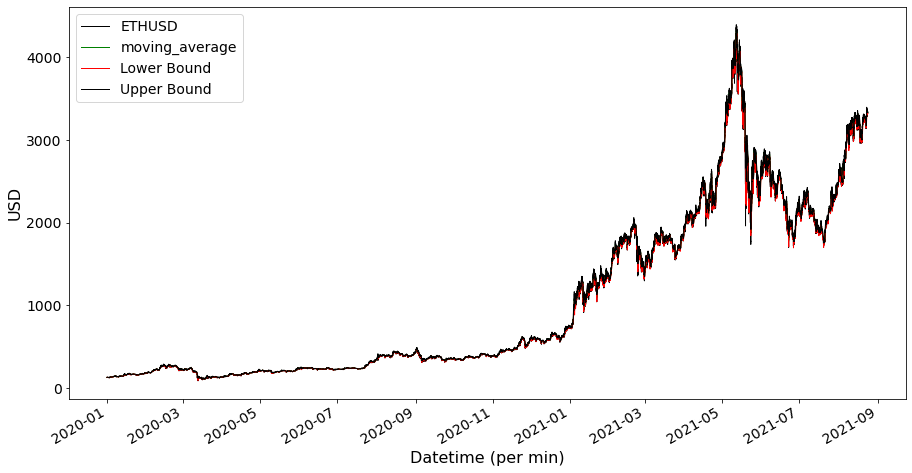

In [92]:
plot_bollinger_bands(eth_bb_data)

## Upward and Downward Trend

In [97]:
upward_eth_bb_data = eth_bb_data[((eth_bb_data.index >= '2021-05-01')&(eth_bb_data.index <= '2021-05-12'))]

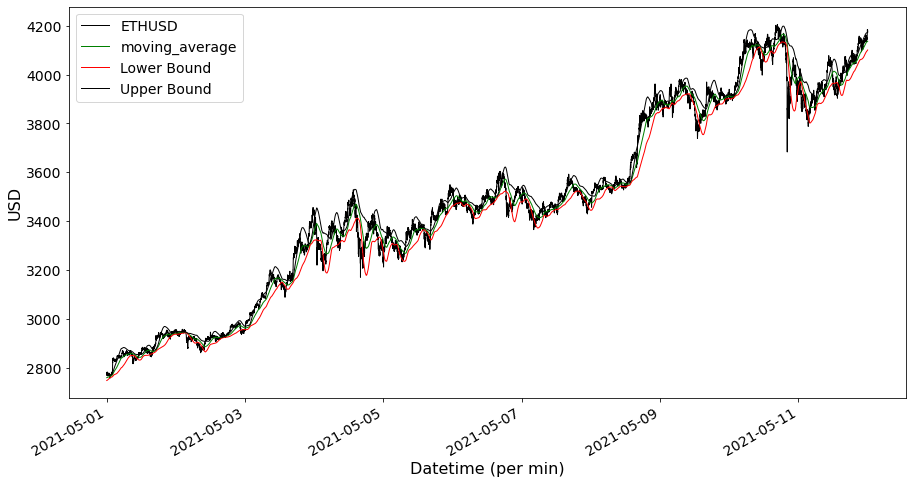

In [98]:
plot_bollinger_bands(upward_eth_bb_data)

In [99]:
downward_eth_bb_data = eth_bb_data[((eth_bb_data.index >= '2021-05-18')&(eth_bb_data.index <= '2021-05-20'))]

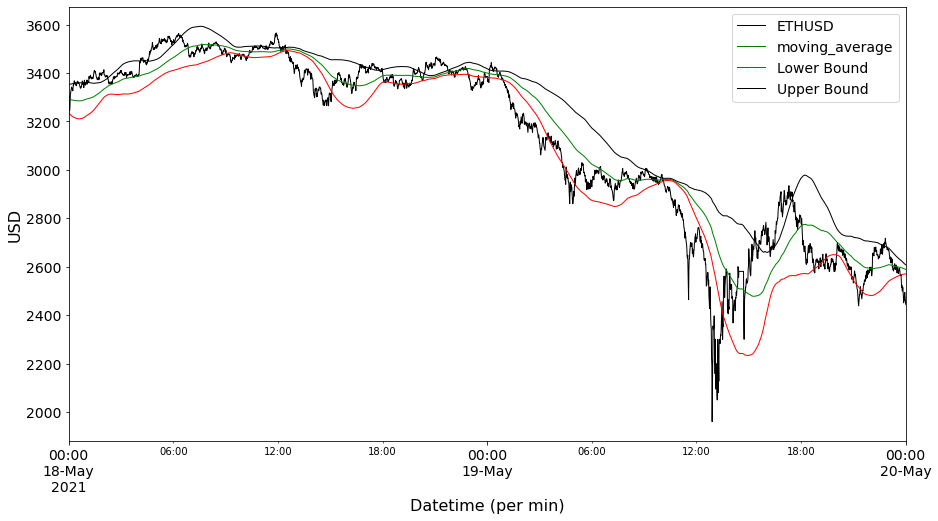

In [100]:
plot_bollinger_bands(downward_eth_bb_data)